In [1]:
import numpy as np
import os
import pandas as pd
import scipy
import dicom
from scipy import stats
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.convolutional import Convolution3D
from keras.layers.pooling import MaxPooling3D
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


In [2]:
sample_images_folder = '/workspace/dsbowl2017/data/sample_images'
patients = os.listdir(sample_images_folder)
patient_id = patients[2]

In [3]:
def scan_dicom(patient_id, patients_folder):
    path = os.path.join(patients_folder, patient_id)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    img = np.stack([s.pixel_array for s in slices])
    img_z = img.shape[0]
    img_x = img.shape[1]
    img_y = img.shape[2]
    spacing = np.array([slices[0].SliceThickness] + slices[0].PixelSpacing, dtype=np.float32)
    output = (patient_id, img_x, img_y, img_z, spacing[1], spacing[2], spacing[0])
    return output


In [4]:
patients_folder = '/workspace/dsbowl2017/data/sample_images'
patients = os.listdir(patients_folder)
patient_id = patients[2]
patients = os.listdir(patients_folder)
output = scan_dicom(patient_id, patients_folder)
output

('0a0c32c9e08cc2ea76a71649de56be6d',
 512,
 512,
 133,
 0.66406202,
 0.66406202,
 2.5)

In [39]:
df_scan_dicom = [scan_dicom(patient_id, patients_folder) for patient_id in patients]
df_scan_dicom = pd.DataFrame.from_records(df_scan_dicom)
df_scan_dicom.columns = ['id', 'img_x_ori', 'img_y_ori', 'img_z_ori', 'spacing_x_ori', 'spacing_y_ori', 'spacing_z_ori']
df_scan_dicom

,id,img_x_ori,img_y_ori,img_z_ori,spacing_x_ori,spacing_y_ori,spacing_z_ori
0,00cba091fa4ad62cc3200a657aeb957e,512,512,134,0.597656,0.597656,2.50
1,0a099f2549429d29b32f349e95fb2244,512,512,128,0.677734,0.677734,2.50
2,0a0c32c9e08cc2ea76a71649de56be6d,512,512,133,0.664062,0.664062,2.50
3,0a38e7597ca26f9374f8ea2770ba870d,512,512,110,0.625000,0.625000,2.50
4,0acbebb8d463b4b9ca88cf38431aac69,512,512,203,0.544922,0.544922,1.80
5,0b20184e0cd497028bdd155d9fb42dc9,512,512,196,0.703125,0.703125,1.80
6,0bd0e3056cbf23a1cb7f0f0b18446068,512,512,280,0.664062,0.664062,1.25
7,0c0de3749d4fe175b7a5098b060982a1,512,512,123,0.693359,0.693359,2.50
8,0c37613214faddf8701ca41e6d43f56e,512,512,164,0.703125,0.703125,2.00
9,0c59313f52304e25d5a7dcf9877633b1,512,512,244,0.761719,0.761719,1.25


In [5]:
def scan(patient_id, preprocessing_folder):
    filename = '%s.npy' %(patient_id)
    img = np.load(os.path.join(preprocessing_folder,filename))
    img_z = img.shape[0]
    img_x = img.shape[1]
    img_y = img.shape[2]
    output = (patient_id, img_x, img_y, img_z)
    return output


In [41]:
df_scan = [scan(patient_id,"/workspace/dsbowl2017/data/preprocessing_images") for patient_id in patients]
df_scan = pd.DataFrame.from_records(df_scan)
df_scan.columns = ['id','img_x','img_y','img_z']

df_label = pd.read_csv( "/workspace/dsbowl2017/data/stage1_labels.csv")
df_label = df_label[df_label.id.isin(patients)]
df_all = pd.merge(df_scan, df_label, on = 'id')
df_all

,id,img_x,img_y,img_z,cancer
0,00cba091fa4ad62cc3200a657aeb957e,306,306,335,0
1,0a099f2549429d29b32f349e95fb2244,347,347,320,0
2,0a0c32c9e08cc2ea76a71649de56be6d,340,340,332,0
3,0a38e7597ca26f9374f8ea2770ba870d,320,320,275,0
4,0acbebb8d463b4b9ca88cf38431aac69,279,279,365,1
5,0bd0e3056cbf23a1cb7f0f0b18446068,340,340,350,0
6,0c0de3749d4fe175b7a5098b060982a1,355,355,308,1
7,0c37613214faddf8701ca41e6d43f56e,360,360,328,1
8,0c59313f52304e25d5a7dcf9877633b1,390,390,305,0
9,0c60f4b87afcb3e2dfa65abbbf3ef2f9,330,330,272,1


In [42]:
df_total = pd.merge(df_scan_dicom, df_all, on='id')
df_total

,id,img_x_ori,img_y_ori,img_z_ori,spacing_x_ori,spacing_y_ori,spacing_z_ori,img_x,img_y,img_z,cancer
0,00cba091fa4ad62cc3200a657aeb957e,512,512,134,0.597656,0.597656,2.50,306,306,335,0
1,0a099f2549429d29b32f349e95fb2244,512,512,128,0.677734,0.677734,2.50,347,347,320,0
2,0a0c32c9e08cc2ea76a71649de56be6d,512,512,133,0.664062,0.664062,2.50,340,340,332,0
3,0a38e7597ca26f9374f8ea2770ba870d,512,512,110,0.625000,0.625000,2.50,320,320,275,0
4,0acbebb8d463b4b9ca88cf38431aac69,512,512,203,0.544922,0.544922,1.80,279,279,365,1
5,0bd0e3056cbf23a1cb7f0f0b18446068,512,512,280,0.664062,0.664062,1.25,340,340,350,0
6,0c0de3749d4fe175b7a5098b060982a1,512,512,123,0.693359,0.693359,2.50,355,355,308,1
7,0c37613214faddf8701ca41e6d43f56e,512,512,164,0.703125,0.703125,2.00,360,360,328,1
8,0c59313f52304e25d5a7dcf9877633b1,512,512,244,0.761719,0.761719,1.25,390,390,305,0
9,0c60f4b87afcb3e2dfa65abbbf3ef2f9,512,512,136,0.644531,0.644531,2.00,330,330,272,1


In [6]:
def shift(img, target_size, max_index):
    image_x_size = img.shape[1]
    image_y_size = img.shape[2]
    image_z_size = img.shape[0]
    if max_index == 0:
        shift_0 = 0
        shift_1 = int((target_size-image_x_size)/2)
        shift_2 = int((target_size-image_y_size)/2)
    elif max_index ==1:
        shift_0 = int((target_size-image_z_size)/2)
        shift_1 = 0
        shift_2 = int((target_size-image_y_size)/2)
    else:
        shift_0 = int((target_size-image_z_size)/2)
        shift_1 = int((target_size-image_x_size)/2)
        shift_2 = 0
    shift = (shift_0, shift_1, shift_2)
    
    return shift
    
    
    

In [7]:
def harmonize(img, target_size):
    max_size = np.max(img.shape)
    max_index = np.argmax(img.shape)
    scale_ratio = target_size/max_size
    zoom_image= scipy.ndimage.interpolation.zoom(img, scale_ratio, mode='nearest')
    image_x_size = zoom_image.shape[1]
    image_y_size = zoom_image.shape[2]
    image_z_size = zoom_image.shape[0]
    #resize_zoom_image = resize(zoom_image, [target_size,target_size,target_size])
    zoom_image_mode = stats.mode(zoom_image[int(zoom_image.shape[0]/2*scale_ratio)].flatten())[0]
    new_img = np.ndarray([target_size,target_size,target_size], dtype=np.float32)
    new_img = new_img+zoom_image_mode
    #np.ndarray([num_images,1,512,512],dtype=np.float32)
    print(new_img.shape)
    print(zoom_image.shape)
    shift_all =shift(zoom_image, target_size, max_index)
    new_img[shift_all[0]:shift_all[0]+image_z_size:,shift_all[1]:shift_all[1]+image_x_size,shift_all[2]:shift_all[2]+image_y_size]=zoom_image
    return new_img

In [8]:
def generate_data_from_directory(path):
    images = [f for f in os.listdir(path) if f.endswith('.npy')]
    labels_info = pd.read_csv('/workspace/dsbowl2017/data/sample_images_.csv', index_col=0)
    labels_info.set_index("id", drop=True, inplace=True)
    while 1:
        for img in images:
            img_id = img.replace('.npy', '')
            if img_id not in labels_info.index:
                continue
            label = np_utils.to_categorical(labels_info.loc[img_id,'cancer'],2)
            img_pixels = np.load(os.path.join(path,img))
            #img_array = np.reshape(harmonize(np.load(os.path.join(path,img)),300), (300, 300, 300, 1))
            img_array = np.reshape(img_pixels,(img_pixels.shape[0],img_pixels.shape[1],img_pixels.shape[2], 1))
            yield (np.reshape(img_array, (1, img_pixels.shape[0],img_pixels.shape[1],img_pixels.shape[2], 1)),label)
    
    

In [9]:
# apply a 3x3 convolution with 64 output filters on a 256x256 image:
model = Sequential()
model.add(Convolution3D(32, 3, 3, 3, border_mode='same',activation='relu', input_shape=(128,256,256, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Convolution3D(32, 3, 3, 3, border_mode='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Convolution3D(16, 3, 3, 3, border_mode='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Convolution3D(16, 3, 3, 3, border_mode='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Convolution3D(8, 3, 3, 3, border_mode='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Convolution3D(8, 3, 3, 3, border_mode='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution3d_1 (Convolution3D)  (None, 128, 256, 256, 896         convolution3d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling3d_1 (MaxPooling3D)    (None, 64, 128, 128,  0           convolution3d_1[0][0]            
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 64, 128, 128,  27680       maxpooling3d_1[0][0]             
____________________________________________________________________________________________________
maxpooling3d_2 (MaxPooling3D)    (None, 32, 64, 64, 32 0           convolution3d_2[0][0]            
___________________________________________________________________________________________

In [14]:
gen = generate_data_from_directory('/workspace/dsbowl2017/data/preprocessing_images_all/')
history = model.fit_generator(gen,
                              samples_per_epoch=19,
                              nb_epoch=3,
                              verbose=1)

Epoch 1/3
13/19 [===================>..........] - ETA: 11179s - loss: 4.9416 - acc: 0.6923

KeyboardInterrupt: 

In [ ]:
files= os.listdir('/workspace/dsbowl2017/data/preprocessing_images_all/')
files
imgg = np.load('/workspace/dsbowl2017/data/preprocessing_images_all/0a38e7597ca26f9374f8ea2770ba870d.npy')
imgg.shape

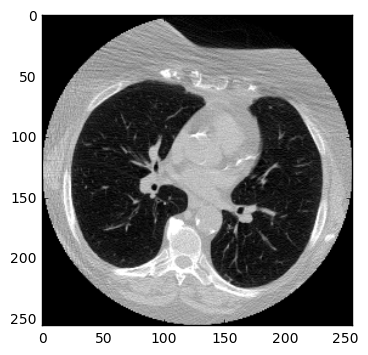

In [13]:
import matplotlib.pyplot as plt

slice_1 = imgg[64]
# Show some slice in the middle
plt.imshow(slice_1, cmap=plt.cm.gray)
plt.show()

In [4]:
train_generator = train_datagen.flow_from_directory(
        '/workspace/dsbowl2017/data/preprocessing_images/',
        target_size=(300, 300, 300),
        batch_size=1,
        class_mode='binary')

Found 0 images belonging to 0 classes.
